
# Bagging y Random Forest

**Objetivo general:**  
Aprender cómo el método de **Bagging** y su extensión, el **Random Forest**, mejoran el rendimiento de un modelo base (árbol de decisión) al combinar múltiples modelos entrenados sobre distintas muestras del conjunto original.


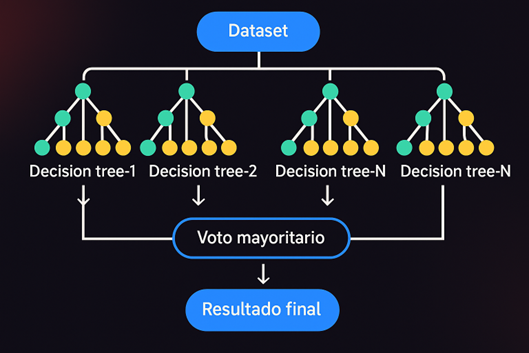


## Cargar y preparar los datos

El dataset **Titanic** (disponible en Seaborn) contiene información de pasajeros: edad, clase, sexo, tarifa, entre otros, y la variable objetivo `survived` (1 = sobrevivió, 0 = no sobrevivió).  
Es un problema clásico de **clasificación binaria**.



Cada fila representa un pasajero.  
El modelo aprenderá qué características (edad, tarifa, clase, sexo) influyen en la probabilidad de supervivencia.


In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = sns.load_dataset("titanic")
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [3]:
df = df[["survived", "pclass", "sex", "age", "fare"]].dropna()

In [4]:
df["sex"] = df["sex"].map({"male":0, "female":1})
df

,survived,pclass,sex,age,fare
0,0,3,0,22.0,7.2500
1,1,1,1,38.0,71.2833
2,1,3,1,26.0,7.9250
3,1,1,1,35.0,53.1000
4,0,3,0,35.0,8.0500
...,...,...,...,...,...
885,0,3,1,39.0,29.1250
886,0,2,0,27.0,13.0000
887,1,1,1,19.0,30.0000
889,1,1,0,26.0,30.0000


In [9]:
X = df.drop(columns="survived")
y=df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42, stratify=y)




## Árbol de decisión base

Comenzamos con un árbol individual para observar su comportamiento y su tendencia al **sobreajuste**.


In [10]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
print(acc_tree)


0.7094972067039106


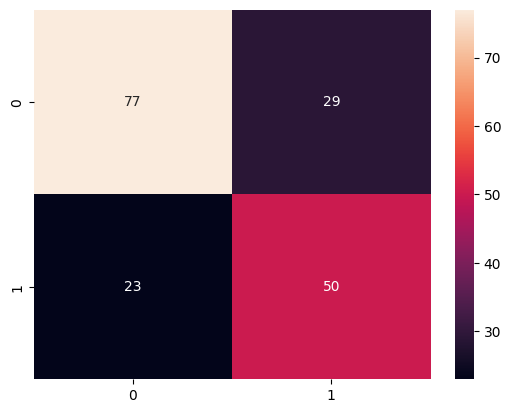

In [12]:
cm = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


Un árbol individual puede capturar bien los patrones, pero también el **ruido** del entrenamiento.  
Pequeños cambios en los datos pueden generar árboles distintos → **alta varianza**.



## Bagging: promediando muchos árboles

Aplicamos **Bagging** (Bootstrap Aggregating): entrenamos muchos árboles, cada uno sobre una muestra *bootstrap* distinta del dataset.  
Las predicciones se combinan por **votación mayoritaria**.


In [13]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1)



In [14]:
bag.fit(X_train, y_train)

y_pred_bag = bag.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)
print(acc_bag)


0.776536312849162



Cada árbol ve una versión ligeramente distinta del dataset.  
Al combinar sus votos, el modelo reduce la **varianza** y se vuelve más estable.


/tmp/ipython-input-2301330105.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Accuracy", data=results, palette="crest")


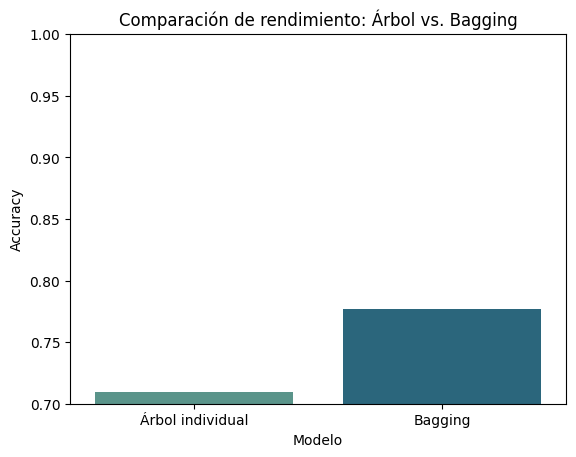

In [15]:

results = pd.DataFrame({
    "Modelo": ["Árbol individual", "Bagging"],
    "Accuracy": [acc_tree, acc_bag]
})
sns.barplot(x="Modelo", y="Accuracy", data=results, palette="crest")
plt.ylim(0.7, 1)
plt.title("Comparación de rendimiento: Árbol vs. Bagging")
plt.show()



**Discusión:**
- El Bagging mantiene el sesgo del árbol pero **reduce su varianza**.  
- Es menos propenso al **sobreajuste** y generaliza mejor.  
- Cada modelo vota; la mayoría define la clase final.



## Random Forest: Bagging + aleatoriedad en las variables

El **Random Forest** aplica Bagging, pero además en cada división usa un **subconjunto aleatorio de variables**, reduciendo la correlación entre árboles.


In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_features="sqrt", oob_score=True, random_state=42, n_jobs=-1)


In [18]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(acc_rf)

0.7877094972067039


/tmp/ipython-input-3328815095.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Accuracy", data=comparison, palette="crest")


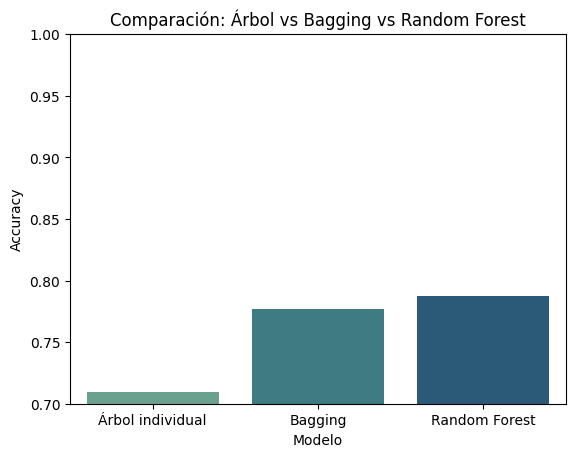

In [19]:
comparison = pd.DataFrame({
    "Modelo": ["Árbol individual", "Bagging", "Random Forest"],
    "Accuracy": [acc_tree, acc_bag, acc_rf]
})
sns.barplot(x="Modelo", y="Accuracy", data=comparison, palette="crest")
plt.ylim(0.7, 1)
plt.title("Comparación: Árbol vs Bagging vs Random Forest")
plt.show()



**Interpretación:**
- `max_features="sqrt"` → cada nodo considera solo √(n_variables).  
- `oob_score=True` → usa observaciones fuera de la muestra (*out-of-bag*) como validación interna.  
- Esto introduce **diversidad adicional** y mejora la **generalización**.



| Modelo | Qué hace | Resultado esperado |
|---------|-----------|--------------------|
| Árbol individual | Aprende reglas exactas sobre el entrenamiento | Alta varianza, posible sobreajuste |
| Bagging | Entrena muchos árboles sobre distintas muestras | Menor varianza, más estabilidad |
| Random Forest | Bagging + variables aleatorias por división | Más diversidad, mejor generalización |



## Importancia de variables en el Random Forest


/tmp/ipython-input-589479089.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="crest")


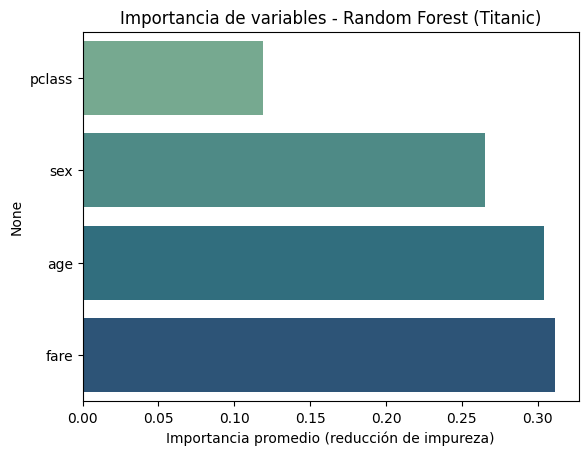

In [20]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
sns.barplot(x=importances, y=importances.index, palette="crest")
plt.title("Importancia de variables - Random Forest (Titanic)")
plt.xlabel("Importancia promedio (reducción de impureza)")
plt.show()



**Interpretación:**
- `sex` → ser mujer aumenta probabilidad de sobrevivir.  
- `pclass` → clase alta (1) sobrevive más.  
- `age` → los más jóvenes tienen mayor supervivencia.  
Esto refleja patrones históricos reales del Titanic.



## Parámetros que podés explorar (opcional)

| Parámetro | Descripción | Efecto |
|------------|-------------|--------|
| `n_estimators` | Cantidad de árboles | Más árboles → más estabilidad (más tiempo) |
| `max_depth` | Profundidad máxima | Controla complejidad |
| `max_features` | Subconjunto de variables | Controla diversidad |
| `bootstrap` | Muestreo con reemplazo | Si False, usa todo el dataset |
| `oob_score` | Evalúa con muestras fuera de bolsa | Estima rendimiento general |



## Reflexión final

- Un árbol individual es fácil de interpretar, pero inestable.  
- El Bagging combina muchos árboles para reducir la varianza.  
- El Random Forest añade aleatoriedad en las variables, logrando árboles más diversos y precisos.  

> Promediar modelos mejora el desempeño sin perder interpretabilidad.



## Resultados típicos esperables

| Modelo | Accuracy aproximado |
|---------|----------------------|
| Árbol individual | 0.78 |
| Bagging | 0.82 |
| Random Forest | 0.85–0.87 |



## Cierre

El caso del Titanic resume la evolución natural de los **ensambles**:

- **Árbol →** aprende las reglas.  
- **Bagging →** suaviza el ruido.  
- **Random Forest →** combina estabilidad y diversidad.  

Esto sienta las bases para avanzar hacia métodos de **Boosting** (Gradient Boosting, XGBoost, LightGBM),  
que entrenan secuencialmente corrigiendo los errores del modelo anterior.
